Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

**TODO!!!**

1. include scaled material parameters - need to check 2ndard materials, and the one that's slightly off
5. density change to eclogite? - in solve loop
7. cohesion and friction coefficient after softening? is it just /2?
8. TranformFaultShape in SchellartEtAl-Science2010+OverRidingPlate.xml - was this used? 
9. Passive tracer swarm

Done
0. calculate viscosityFn,etc, for rheology  - DONE!
2. include material layout - TODO, clip ribbon in z dim
6. larger perturbation? - DONE! (hacketty hacketty)
3. density scaling? DONE!
4. variable resolution?   - Leave for now


In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
import UWGeodynamics as GEO
import scipy

loaded rc file /usr/local/lib/python3.5/dist-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

In [3]:
u = GEO.UnitRegistry

In [4]:
# parameters of interest!
Tsurf = 273.15 * u.degK
Tint  = 1573.0 * u.degK
kappa = 1e-6   * u.meter**2 / u.second 
alpha = 3.0e-5 / u.kelvin

**Scaling**

In [5]:
mantle_density = 3400 * u.kilogram / u.metre**3 # at surface
ref_viscosity  = 1e20 * u.pascal * u.second 
ref_density   = mantle_density * (Tint-Tsurf) * alpha

kappa          = 1e-6 * u.meter**2 / u.second   # thermal diffusion

bodyforce      = mantle_density * 9.81 * u.meter / u.second**2

In [6]:
# KL = 1000.0 * u.kilometer      # length scale
# Kt = KL**2 / kappa             # time scale
# KM = ref_viscosity * KL * Kt   # mass scale 

KL = 1000.0 * u.kilometer            # length scale
KM = mantle_density * KL**3          # mass scale 
Kt = ref_viscosity / bodyforce / KL  # time scale


GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [7]:
print(KL.to('kilometer'))
print(KM.to_base_units())
print(Kt.to('year'))

1000.0 kilometer
3.4e+21 kilogram
95.00738934106403 year


**Setup parameters**


In [8]:
xRes = 32 # 256  
yRes = 64 # 96
zRes = 32 # 96
dim = 2

In [9]:
# Domain
boxLength = 10000.0 * u.kilometer
boxHeight =   800.0 * u.kilometer
boxWidth  =  3000.0 * u.kilometer

**Create mesh and finite element variables**

In [10]:
if dim==2:
    elementRes  = (xRes, yRes)
    minCoord    = (0., -GEO.nd(boxHeight)) 
    maxCoord    = (GEO.nd(boxLength), 0.)
else:
    elementRes  = (xRes, yRes, zRes)
    minCoord    = (0., -GEO.nd(boxHeight), 0.) 
    maxCoord    = (GEO.nd(boxLength), 0., GEO.nd(boxWidth))

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = elementRes, 
                                 minCoord    = minCoord,
                                 maxCoord    = maxCoord,
                               ) 

In [11]:
velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

In [12]:
figsize=(1200,300)


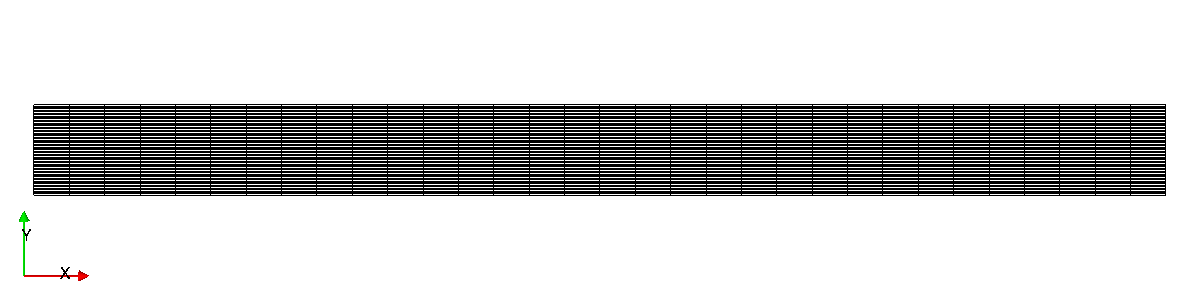

In [13]:
figMesh = glucifer.Figure(figsize=figsize, axis=True, )
figMesh.append( glucifer.objects.Mesh(mesh) )
figMesh.show()
figMesh.open_viewer()

**Define material properties**

In [14]:
# Material properties
um = {
    'name'     : 'upper mantle',
    'index'    : 0,
    'viscosity': ref_viscosity,
    'density'  : 3400 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

lm = {
    'name'     : 'lower mantle',
    'index'    : 1,
    'viscosity': 100.*ref_viscosity,
    'density'  : 3400 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

In [15]:
subplate1 = {
    'name'     : 'oceanic plate 1',
    'index'    : 2,
    'viscosity':  1e5  * ref_viscosity,
    'density'  : 2900  * u.kilogram / u.metre**3,
    'plastic'  : True,
    'friction_coefficient': 0.066,
    'cohesion' : 12.5  * u.megapascal,
    'cohesion2':  6.25 * u.megapascal,         # this is an estimate from Extended Data Figure 2 plot
}

subplate2 = {
    'name'     : 'oceanic plate 2',
    'index'    : 3,
    'viscosity':  1e5  * ref_viscosity,
    'density'  : 3400  * u.kilogram / u.metre**3,
    'plastic'  : True,
    'friction_coefficient': 0.066,
    'cohesion' : 65.46  * u.megapascal,
    'cohesion2':  30.0 * u.megapascal,      
}

          
subplate3 = {
    'name'     : 'oceanic plate 3',
    'index'    : 4,
    'viscosity': 18440.51 * ref_viscosity,
    'density'  : 3400  * u.kilogram / u.metre**3,
    'plastic'  : True,
    'friction_coefficient': 0.066,
    'cohesion' : 120.14 * u.megapascal,
    'cohesion2':  30.0 * u.megapascal,      
}

subplate4 = {
    'name'     : 'oceanic plate 4',
    'index'    : 5,
    'viscosity': 93.36 * ref_viscosity,
    'density'  : 3400  * u.kilogram / u.metre**3,
    'plastic'  : False, 
    'cohesion' : 1e3 * u.megapascal,
}


In [16]:
backArc1 = {
    'name'     : 'ribbon',
    'index'    : 6,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}
backArc2 = {
    'name'     : 'ribbon',
    'index'    : 7,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

In [17]:
trans1 = {
    'name'     : 'trans1',
    'index'    : 8,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}
trans2 = {
    'name'     : 'trans2',
    'index'    : 9,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

craton1 = {
    'name'     : 'craton1',
    'index'    : 10,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

craton2 = {
    'name'     : 'craton2',
    'index'    : 11,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

ribbon = {
    'name'     : 'ribbon',
    'index'    : 12,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

buoyStrip = {
    'name'     : 'buoyStrip',
    'index'    : 13,
    'viscosity':  1e5 * ref_viscosity,
    'density'  : 2900 * u.kilogram / u.metre**3,
    'plastic'  : False,
    'cohesion' : 1e3 * u.megapascal,
}

In [18]:
# define material list
material_list = [ um, lm, 
                 subplate1, subplate2, subplate3, subplate4, 
                 backArc1, backArc2, 
                 trans1, trans2, 
                 craton1, craton2, 
                 ribbon, 
                 buoyStrip ]

**Create a particle swarm**

In [19]:
swarm       = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

materialIndex = swarm.add_variable( dataType="int", count=1 )

In [20]:
# I assume here the origin is a the top, front, middle
# 'middle' being the slab hinge at top, front
pert = 0.2  # nondimensional pert 
slab_xStart = 2500. * u.kilometer
slab_dx = 7000.0 * u.kilometer
slab_dy =  100.0 * u.kilometer
slab_dz = 3000.0 * u.kilometer # this is the entire domain width
slab_layers = 4

In [21]:
backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2

trans_dx =  350. * u.kilometer
trans_dy =  100. * u.kilometer
trans_xStart = slab_xStart - backarc_dx - trans_dx
trans_layers = 2

craton_dx = 750. * u.kilometer
craton_dy = 150. * u.kilometer
craton_xStart = slab_xStart - backarc_dx - trans_dx - craton_dx
craton_layers = 2

ribbon_dx =  500. * u.kilometer
ribbon_dy =   50. * u.kilometer
ribbon_dz = 1500. * u.kilometer 
ribbon_xStart = slab_xStart + 500. * u.kilometer

bouyStrip_dx = 500. * u.kilometer
bouyStrip_dy =  50. * u.kilometer
bouyStrip_xStart = slab_xStart + slab_dx - bouyStrip_dx

In [22]:
def slabGeo(x, y, dx, dy,):
    slabShape = np.array([ (x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy), (x-pert,y-dy-pert), (x-pert,y-dy-pert) ])
    return fn.shape.Polygon(slabShape)

In [23]:
def backArcGeo(x, y, dx, dy,):
    backArcShape = np.array([ (x,y), (x+dx,y), (x+dx-pert,y-dy), (x,y-dy)])
    return fn.shape.Polygon(backArcShape)

In [24]:
def boxGeo(x, y, dx, dy):
    boxShape = np.array([(x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy)]) 
    return (fn.shape.Polygon(boxShape))

In [25]:
def ribbonGeo(x, y, dx, dy):
    boxShape = np.array([(x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy)]) 
    return (fn.shape.Polygon(boxShape) or (fn.input()[2] < 1.5))

In [26]:
#coord = fn.input()
def ribbonGeo2(x, y, dx, dy):
    boxShape = np.array([(x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy)]) 
    if (coord[2] < 1.5):
        return fn.shape.Polygon(boxShape)    
    return False    

In [27]:
def ribbonGeo3(x, y, z, dx, dy, dz):
    coord = fn.input()
    func = (
        (coord[0] <= dx) &
        (coord[0] >=  x) &
        (coord[1] <= dy) &
        (coord[1] >=  y) &
        (coord[2] <= dz) &
        (coord[2] >=  z) )
    return func

In [28]:
# Set materials
conditions = [ 
               ( fn.input()[1] < GEO.nd( -600.0 * 10**3 * u.meter ), lm['index']) ,
                # define ribbon gemetry
               ( ribbonGeo(GEO.nd(ribbon_xStart), 0., GEO.nd(ribbon_dx), GEO.nd(ribbon_dy)), ribbon['index']),
#               ( ribbonGeo2(GEO.nd(ribbon_xStart), 0., GEO.nd(ribbon_dx), GEO.nd(ribbon_dy)), ribbon['index']),
#               ( (fn.input()[0] < 1.5) and (boxGeo(GEO.nd(ribbon_xStart), 0., GEO.nd(ribbon_dx), GEO.nd(ribbon_dy))), ribbon['index']),
#               ( ribbonGeo3(GEO.nd(ribbon_xStart), 0., 0., GEO.nd(ribbon_dx), GEO.nd(ribbon_dy), GEO.nd(ribbon_dz)), ribbon['index']),
                # define buoyant strip gemetry
               ( boxGeo(GEO.nd(bouyStrip_xStart), 0., GEO.nd(bouyStrip_dx), GEO.nd(bouyStrip_dy)), buoyStrip['index']),
                # define slab geometery
               ( slabGeo(GEO.nd(slab_xStart), -0.*GEO.nd(slab_dy)/slab_layers, GEO.nd(slab_dx), GEO.nd(slab_dy)), subplate1['index']),
               ( slabGeo(GEO.nd(slab_xStart), -1.*GEO.nd(slab_dy)/slab_layers, GEO.nd(slab_dx), GEO.nd(slab_dy)), subplate2['index']),
               ( slabGeo(GEO.nd(slab_xStart), -2.*GEO.nd(slab_dy)/slab_layers, GEO.nd(slab_dx), GEO.nd(slab_dy)), subplate3['index']),
               ( slabGeo(GEO.nd(slab_xStart), -3.*GEO.nd(slab_dy)/slab_layers, GEO.nd(slab_dx), GEO.nd(slab_dy)), subplate4['index']),
                # dedine back arc geometry
               ( backArcGeo(GEO.nd(backarc_xStart),  -0.*GEO.nd(backarc_dy)/backarc_layers, GEO.nd(backarc_dx), GEO.nd(backarc_dy)), backArc1['index']),
               ( backArcGeo(GEO.nd(backarc_xStart),  -1.*GEO.nd(backarc_dy)/backarc_layers, GEO.nd(backarc_dx), GEO.nd(backarc_dy)), backArc2['index']),
                # define transition gemetry
               ( boxGeo(GEO.nd(trans_xStart),  -0.*GEO.nd(trans_dy)/trans_layers, GEO.nd(trans_dx), GEO.nd(trans_dy)), trans1['index']),
               ( boxGeo(GEO.nd(trans_xStart),  -1.*GEO.nd(trans_dy)/trans_layers, GEO.nd(trans_dx), GEO.nd(trans_dy)), trans2['index']),
                # define craton gemetry
               ( boxGeo(GEO.nd(craton_xStart), -0.*GEO.nd(craton_dy)/craton_layers, GEO.nd(craton_dx), GEO.nd(craton_dy)), craton1['index']),
               ( boxGeo(GEO.nd(craton_xStart), -1.*GEO.nd(craton_dy)/craton_layers, GEO.nd(craton_dx), GEO.nd(craton_dy)), craton2['index']),
                # otherwise upper mantle!
                ( True, um['index']),
             ] 

In [29]:
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


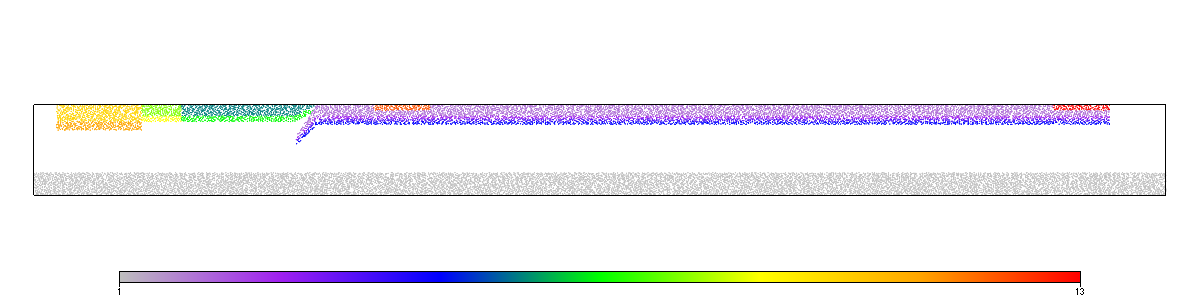

In [30]:
materialFilter = materialIndex > 0
colours=['Grey', 'Purple', 'Blue', 'Green', 'Yellow', 'Orange', 'Red']

figSwarm = glucifer.Figure(figsize=figsize)
figSwarm.append( glucifer.objects.Points(swarm, materialIndex, materialFilter, colours=colours, fn_size=2.) )
figSwarm
figSwarm.show()

In [31]:
if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
lv = figSwarm.window()
lv.rotate(30)
lv.zoom(-7)
lv.redisplay()
lv.axis()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
##Set cohesion (max stress) fn
cohesionMap = {              um['index'] : GEO.nd(um['cohesion']), 
                             lm['index'] : GEO.nd(lm['cohesion']), 
                      subplate1['index'] : GEO.nd(subplate1['cohesion']), 
                      subplate2['index'] : GEO.nd(subplate2['cohesion']), 
                      subplate3['index'] : GEO.nd(subplate3['cohesion']), 
                      subplate4['index'] : GEO.nd(subplate4['cohesion']), 
                       backArc1['index'] : GEO.nd(backArc1['cohesion']), 
                       backArc2['index'] : GEO.nd(backArc2['cohesion']), 
                         trans1['index'] : GEO.nd(trans1['cohesion']), 
                         trans2['index'] : GEO.nd(trans2['cohesion']), 
                        craton1['index'] : GEO.nd(craton1['cohesion']), 
                        craton2['index'] : GEO.nd(craton2['cohesion']), 
                         ribbon['index'] : GEO.nd(ribbon['cohesion']), 
                      buoyStrip['index'] : GEO.nd(buoyStrip['cohesion']),
                    }
cohesionFn = fn.branching.map( fn_key = materialIndex, mapping = cohesionMap )

In [33]:
##Set linear viscosity fn
linearViscosityMap = {       um['index'] : GEO.nd(um['viscosity']), 
                             lm['index'] : GEO.nd(lm['viscosity']), 
                      subplate1['index'] : GEO.nd(subplate1['viscosity']), 
                      subplate2['index'] : GEO.nd(subplate2['viscosity']), 
                      subplate3['index'] : GEO.nd(subplate3['viscosity']), 
                      subplate4['index'] : GEO.nd(subplate4['viscosity']), 
                       backArc1['index'] : GEO.nd(backArc1['viscosity']), 
                       backArc2['index'] : GEO.nd(backArc2['viscosity']), 
                         trans1['index'] : GEO.nd(trans1['viscosity']), 
                         trans2['index'] : GEO.nd(trans2['viscosity']), 
                        craton1['index'] : GEO.nd(craton1['viscosity']), 
                        craton2['index'] : GEO.nd(craton2['viscosity']), 
                         ribbon['index'] : GEO.nd(ribbon['viscosity']), 
                      buoyStrip['index'] : GEO.nd(buoyStrip['viscosity']),
                    }

linearViscosityFn = fn.branching.map( fn_key = materialIndex, mapping = linearViscosityMap )

In [34]:
minViscosity = ref_viscosity
maxViscosity = ref_viscosity*1.0e5

strainRate_2ndInvariant = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.fn_gradient ))

vonMises    = 0.5 * cohesionFn / (strainRate_2ndInvariant + 1.0e-18)     
viscosityFn = fn.exception.SafeMaths( fn.misc.max(GEO.nd(minViscosity), fn.misc.min(vonMises, linearViscosityFn) ))


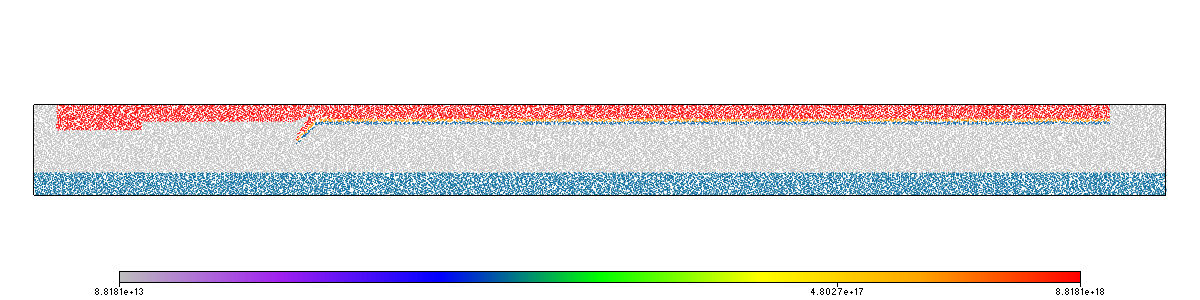

In [35]:
figViscosity = glucifer.Figure(figsize=figsize)
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, colours=colours, fn_size=2., logScale=True) )
figViscosity.show()

In [36]:
if not glucifer.lavavu: raise KeyboardInterrupt #Stop notebook here if no vis enabled
lv = figViscosity.window()
lv.rotate(30)
lv.zoom(-7)
lv.redisplay()
lv.axis()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# **Get density scaling and values from Dave Willis file**

# def calculateOceanicLayering 
# density.append(DensityLayer[densitylayer] * (1 - (temp[index] - Tsurf) * alpha ))

**Define temperature and density functions**

In [38]:
coord = fn.input()
depthFn = -1.0 * boxHeight * coord[1] 

In [39]:
# for oceanic lithosphere thickness
def half_space_cooling(depth,age):
    return GEO.nd(Tsurf) +GEO.nd(Tint-Tsurf) * fn.math.erf(depth/(2*np.sqrt(GEO.nd(age*kappa))))

In [40]:
# age of oceanic lithosphere
age = 80. * 10**6 * u.year

In [41]:
# temperature profile of lithosphere
temperature = half_space_cooling(GEO.nd(depthFn), GEO.nd(age))

In [42]:
##Set density fn
rhoMap = {                  um['index']  : GEO.nd(um['density']), 
                             lm['index'] : GEO.nd(lm['density']), 
                      subplate1['index'] : GEO.nd(subplate1['density']), 
                      subplate2['index'] : GEO.nd(subplate2['density']), 
                      subplate3['index'] : GEO.nd(subplate3['density']), 
                      subplate4['index'] : GEO.nd(subplate4['density']), 
                       backArc1['index'] : GEO.nd(backArc1['density']), 
                       backArc2['index'] : GEO.nd(backArc2['density']), 
                         trans1['index'] : GEO.nd(trans1['density']), 
                         trans2['index'] : GEO.nd(trans2['density']), 
                        craton1['index'] : GEO.nd(craton1['density']), 
                        craton2['index'] : GEO.nd(craton2['density']), 
                         ribbon['index'] : GEO.nd(ribbon['density']), 
                      buoyStrip['index'] : GEO.nd(buoyStrip['density']),
                    }

rhoFn = fn.branching.map( fn_key = materialIndex, mapping = rhoMap )

In [43]:
deltaT  = temperature - GEO.nd(Tsurf)

In [47]:
#ref_density, 
rhoFn

In [48]:
densityFn = (rhoFn - rhoFn * deltaT * GEO.nd(alpha))/GEO.nd(ref_density)

**This is where I am**

Need to consider the scalling here. things are large


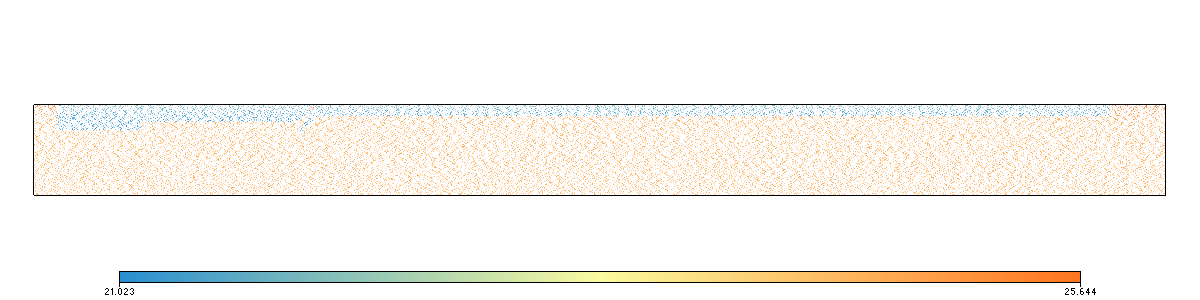

In [49]:
figTest = glucifer.Figure(figsize=figsize)
#figTest.append( glucifer.objects.Surface(mesh, GEO.nd(depthFn)))
#figTest.append( glucifer.objects.Surface(mesh, temperature))
figTest.append( glucifer.objects.Points(swarm, densityFn))
figTest.show()

**TODO: Eclogite transition**

We assume that the oceanic crust transforms instantaneously and com- pletely to eclogite at a depth of 150 km (density 3,500 kg m23 at the surface temperature).

**Set the density function, vertical unit vector and Buoyancy Force function**


In [ ]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    z_hat = ( 0.0, 1.0)
else:
    z_hat = ( 0.0, 1.0, 0.0 )    

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set initial and boundary conditions**

In [ ]:
# set initial conditions (and boundary values)
if dim==2:
    velocityField.data[:] = [0.,0.]
else:
    velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.

# send boundary condition information to underworld
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
if dim==2:
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls) ) 
    
if dim==3:
    kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]    
    freeSlipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                   indexSetsPerDof = ( iWalls, jWalls, kWalls) ) 

**System Setup**

In [ ]:
# Initial linear slab viscosity setup
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               voronoi_swarm = swarm, 
                               conditions    = freeSlipBC,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [ ]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

In [ ]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [ ]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [ ]:
time = 0.  # Initial time
step = 0   # Initial timestep
maxSteps = 3      # Maximum timesteps (201 is recommended)
steps_output = 10   # output every 10 timesteps

In [ ]:
store = glucifer.Store(outputPath + 'moresi-2014-slab{0}.gldb'.format(str(step).zfill(5)))

#Plot of Velocity Magnitude
figVelocityMag = glucifer.Figure(store, figsize=(960,300))
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField))) )

#Plot of Strain Rate, 2nd Invariant
figStrainRate = glucifer.Figure(store, figsize=(960,300))
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True) )

#Plot of particles viscosity
figViscosity = glucifer.Figure(store, figsize=(960,300))
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=2) )

#Plot of particles stress invariant
figStress = glucifer.Figure( store, figsize=(960,300) )
figStress.append( glucifer.objects.Points(swarm, 2.0*viscosityFn*strainRate_2ndInvariant, pointSize=2, logScale=True) )

In [ ]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # Advect using this timestep size.
    advector.integrate(dt)
    return time+dt, step+1

In [ ]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        #Important to set the timestep for the store object here or will overwrite previous step
        store.step = step
        figParticle.save(    outputPath + "particle"    + str(step).zfill(4))
        figVelocityMag.save( outputPath + "velocityMag" + str(step).zfill(4))
        figStrainRate.save(  outputPath + "strainRate"  + str(step).zfill(4))
        figViscosity.save(   outputPath + "viscosity"   + str(step).zfill(4))
        figStress.save(      outputPath + "stress"      + str(step).zfill(4))
        
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        print('step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms))

    # update
    time,step = update()

Post simulation analysis
-----

Plot all figures for the resulting system using LavaVu to load the saved visualisation.
This allows us to open a previously saved visualisation database, just pass the same name used when creating the Store object

In [ ]:
import glucifer
saved = glucifer.Viewer('output/moresi-2014-slab{0}.gldb')

Here we print some information about the loaded visualisation which shows what data is available
(as we only gave our first figure a name "Particles" the others have been automatically named)

In [ ]:
figs = saved.figures
steps = saved.steps
print("Saved database '%s'" % (saved.filename))
print(" - %d figures : %s" % (len(figs), str(figs.keys())))
print(" - %d timesteps (final = %d) : %s" % (len(steps), steps[-1], steps))

We just want to look at the final state of the simulation, so set the timestep to the last one in the list and loop through all the figures, plotting each one

In [ ]:
#Re-visualise the final timestep
saved.step = steps[-1]
for name in saved.figures:
    saved.figure(name)
    saved["quality"] = 2
    saved["title"] = "Timestep ##"
    saved.show()